# sEMG LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.semg_utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [3]:
X_train, labels_train, list_ch_train = read_data(data_path="C:\\Users\\paperspace\\sEMG-Neural-Net\\sEMG\\Database 2\\male_day_1\\", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="C:\\Users\\paperspace\\sEMG-Neural-Net\\sEMG\\Database 2\\male_day_2\\", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [4]:
# Standardize
X_train, X_test = standardize(X_train, X_test) 

Train/Validation Split

In [5]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

One-hot encoding:

In [6]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [7]:
# Imports
import tensorflow as tf

lstm_size = 6         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 20       # Batch size
seq_len = 2500          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 2
n_channels = 2

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [9]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

C:\Users\paperspace\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Define forward pass, cost function and optimizer:

In [11]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

ValueError: Variable logits/kernel already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Users\paperspace\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()
  File "C:\Users\paperspace\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\paperspace\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)


### Train the network

In [12]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [13]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 0.716147 Train acc: 0.550000
Epoch: 1/1000 Iteration: 10 Train loss: 0.733120 Train acc: 0.450000
Epoch: 2/1000 Iteration: 15 Train loss: 0.679358 Train acc: 0.450000
Epoch: 2/1000 Iteration: 20 Train loss: 0.792559 Train acc: 0.250000
Epoch: 3/1000 Iteration: 25 Train loss: 0.732091 Train acc: 0.550000
Epoch: 3/1000 Iteration: 25 Validation loss: 0.718019 Validation acc: 0.425000
Epoch: 4/1000 Iteration: 30 Train loss: 0.694964 Train acc: 0.600000
Epoch: 4/1000 Iteration: 35 Train loss: 0.707198 Train acc: 0.400000
Epoch: 5/1000 Iteration: 40 Train loss: 0.749710 Train acc: 0.500000
Epoch: 6/1000 Iteration: 45 Train loss: 0.689637 Train acc: 0.600000
Epoch: 7/1000 Iteration: 50 Train loss: 0.693615 Train acc: 0.500000
Epoch: 7/1000 Iteration: 50 Validation loss: 0.716840 Validation acc: 0.400000
Epoch: 7/1000 Iteration: 55 Train loss: 0.753729 Train acc: 0.400000
Epoch: 8/1000 Iteration: 60 Train loss: 0.739387 Train acc: 0.450000
Epoch: 9/1000 I

Epoch: 68/1000 Iteration: 480 Train loss: 0.708209 Train acc: 0.450000
Epoch: 69/1000 Iteration: 485 Train loss: 0.681497 Train acc: 0.550000
Epoch: 69/1000 Iteration: 490 Train loss: 0.722801 Train acc: 0.400000
Epoch: 70/1000 Iteration: 495 Train loss: 0.685894 Train acc: 0.650000
Epoch: 71/1000 Iteration: 500 Train loss: 0.714080 Train acc: 0.350000
Epoch: 71/1000 Iteration: 500 Validation loss: 0.704584 Validation acc: 0.425000
Epoch: 72/1000 Iteration: 505 Train loss: 0.683300 Train acc: 0.600000
Epoch: 72/1000 Iteration: 510 Train loss: 0.702109 Train acc: 0.450000
Epoch: 73/1000 Iteration: 515 Train loss: 0.704882 Train acc: 0.500000
Epoch: 74/1000 Iteration: 520 Train loss: 0.698540 Train acc: 0.450000
Epoch: 74/1000 Iteration: 525 Train loss: 0.675245 Train acc: 0.700000
Epoch: 74/1000 Iteration: 525 Validation loss: 0.704101 Validation acc: 0.425000
Epoch: 75/1000 Iteration: 530 Train loss: 0.696998 Train acc: 0.450000
Epoch: 76/1000 Iteration: 535 Train loss: 0.699729 Train 

Epoch: 135/1000 Iteration: 950 Validation loss: 0.699782 Validation acc: 0.450000
Epoch: 136/1000 Iteration: 955 Train loss: 0.700150 Train acc: 0.400000
Epoch: 137/1000 Iteration: 960 Train loss: 0.699360 Train acc: 0.450000
Epoch: 137/1000 Iteration: 965 Train loss: 0.688077 Train acc: 0.500000
Epoch: 138/1000 Iteration: 970 Train loss: 0.716549 Train acc: 0.400000
Epoch: 139/1000 Iteration: 975 Train loss: 0.681008 Train acc: 0.450000
Epoch: 139/1000 Iteration: 975 Validation loss: 0.699667 Validation acc: 0.450000
Epoch: 139/1000 Iteration: 980 Train loss: 0.674527 Train acc: 0.600000
Epoch: 140/1000 Iteration: 985 Train loss: 0.693092 Train acc: 0.500000
Epoch: 141/1000 Iteration: 990 Train loss: 0.694081 Train acc: 0.500000
Epoch: 142/1000 Iteration: 995 Train loss: 0.693383 Train acc: 0.450000
Epoch: 142/1000 Iteration: 1000 Train loss: 0.696748 Train acc: 0.450000
Epoch: 142/1000 Iteration: 1000 Validation loss: 0.699494 Validation acc: 0.450000
Epoch: 143/1000 Iteration: 1005 

Epoch: 201/1000 Iteration: 1410 Train loss: 0.693089 Train acc: 0.400000
Epoch: 202/1000 Iteration: 1415 Train loss: 0.707275 Train acc: 0.350000
Epoch: 202/1000 Iteration: 1420 Train loss: 0.693438 Train acc: 0.400000
Epoch: 203/1000 Iteration: 1425 Train loss: 0.707612 Train acc: 0.350000
Epoch: 203/1000 Iteration: 1425 Validation loss: 0.696744 Validation acc: 0.475000
Epoch: 204/1000 Iteration: 1430 Train loss: 0.682524 Train acc: 0.500000
Epoch: 204/1000 Iteration: 1435 Train loss: 0.693409 Train acc: 0.650000
Epoch: 205/1000 Iteration: 1440 Train loss: 0.689101 Train acc: 0.500000
Epoch: 206/1000 Iteration: 1445 Train loss: 0.688284 Train acc: 0.550000
Epoch: 207/1000 Iteration: 1450 Train loss: 0.709278 Train acc: 0.450000
Epoch: 207/1000 Iteration: 1450 Validation loss: 0.696606 Validation acc: 0.475000
Epoch: 207/1000 Iteration: 1455 Train loss: 0.699318 Train acc: 0.350000
Epoch: 208/1000 Iteration: 1460 Train loss: 0.682468 Train acc: 0.600000
Epoch: 209/1000 Iteration: 1465

Epoch: 267/1000 Iteration: 1870 Train loss: 0.693783 Train acc: 0.500000
Epoch: 267/1000 Iteration: 1875 Train loss: 0.673538 Train acc: 0.800000
Epoch: 267/1000 Iteration: 1875 Validation loss: 0.694715 Validation acc: 0.500000
Epoch: 268/1000 Iteration: 1880 Train loss: 0.691842 Train acc: 0.400000
Epoch: 269/1000 Iteration: 1885 Train loss: 0.690246 Train acc: 0.550000
Epoch: 269/1000 Iteration: 1890 Train loss: 0.694257 Train acc: 0.500000
Epoch: 270/1000 Iteration: 1895 Train loss: 0.682200 Train acc: 0.700000
Epoch: 271/1000 Iteration: 1900 Train loss: 0.684597 Train acc: 0.600000
Epoch: 271/1000 Iteration: 1900 Validation loss: 0.694593 Validation acc: 0.500000
Epoch: 272/1000 Iteration: 1905 Train loss: 0.684942 Train acc: 0.700000
Epoch: 272/1000 Iteration: 1910 Train loss: 0.674472 Train acc: 0.700000
Epoch: 273/1000 Iteration: 1915 Train loss: 0.685603 Train acc: 0.600000
Epoch: 274/1000 Iteration: 1920 Train loss: 0.679908 Train acc: 0.500000
Epoch: 274/1000 Iteration: 1925

Epoch: 332/1000 Iteration: 2325 Validation loss: 0.692324 Validation acc: 0.500000
Epoch: 332/1000 Iteration: 2330 Train loss: 0.674215 Train acc: 0.700000
Epoch: 333/1000 Iteration: 2335 Train loss: 0.692628 Train acc: 0.500000
Epoch: 334/1000 Iteration: 2340 Train loss: 0.691856 Train acc: 0.500000
Epoch: 334/1000 Iteration: 2345 Train loss: 0.681853 Train acc: 0.550000
Epoch: 335/1000 Iteration: 2350 Train loss: 0.682452 Train acc: 0.600000
Epoch: 335/1000 Iteration: 2350 Validation loss: 0.692224 Validation acc: 0.500000
Epoch: 336/1000 Iteration: 2355 Train loss: 0.686079 Train acc: 0.500000
Epoch: 337/1000 Iteration: 2360 Train loss: 0.692598 Train acc: 0.600000
Epoch: 337/1000 Iteration: 2365 Train loss: 0.691970 Train acc: 0.450000
Epoch: 338/1000 Iteration: 2370 Train loss: 0.685947 Train acc: 0.500000
Epoch: 339/1000 Iteration: 2375 Train loss: 0.690764 Train acc: 0.550000
Epoch: 339/1000 Iteration: 2375 Validation loss: 0.692082 Validation acc: 0.500000
Epoch: 339/1000 Itera

Epoch: 397/1000 Iteration: 2785 Train loss: 0.662205 Train acc: 0.650000
Epoch: 398/1000 Iteration: 2790 Train loss: 0.690825 Train acc: 0.500000
Epoch: 399/1000 Iteration: 2795 Train loss: 0.690818 Train acc: 0.550000
Epoch: 399/1000 Iteration: 2800 Train loss: 0.684739 Train acc: 0.550000
Epoch: 399/1000 Iteration: 2800 Validation loss: 0.687092 Validation acc: 0.600000
Epoch: 400/1000 Iteration: 2805 Train loss: 0.683950 Train acc: 0.500000
Epoch: 401/1000 Iteration: 2810 Train loss: 0.693148 Train acc: 0.500000
Epoch: 402/1000 Iteration: 2815 Train loss: 0.693591 Train acc: 0.400000
Epoch: 402/1000 Iteration: 2820 Train loss: 0.660709 Train acc: 0.800000
Epoch: 403/1000 Iteration: 2825 Train loss: 0.683631 Train acc: 0.600000
Epoch: 403/1000 Iteration: 2825 Validation loss: 0.686739 Validation acc: 0.600000
Epoch: 404/1000 Iteration: 2830 Train loss: 0.681328 Train acc: 0.550000
Epoch: 404/1000 Iteration: 2835 Train loss: 0.656857 Train acc: 0.800000
Epoch: 405/1000 Iteration: 2840

Epoch: 463/1000 Iteration: 3245 Train loss: 0.670982 Train acc: 0.500000
Epoch: 464/1000 Iteration: 3250 Train loss: 0.692167 Train acc: 0.600000
Epoch: 464/1000 Iteration: 3250 Validation loss: 0.672830 Validation acc: 0.675000
Epoch: 464/1000 Iteration: 3255 Train loss: 0.676871 Train acc: 0.450000
Epoch: 465/1000 Iteration: 3260 Train loss: 0.671389 Train acc: 0.650000
Epoch: 466/1000 Iteration: 3265 Train loss: 0.666281 Train acc: 0.600000
Epoch: 467/1000 Iteration: 3270 Train loss: 0.702069 Train acc: 0.500000
Epoch: 467/1000 Iteration: 3275 Train loss: 0.653293 Train acc: 0.650000
Epoch: 467/1000 Iteration: 3275 Validation loss: 0.671390 Validation acc: 0.675000
Epoch: 468/1000 Iteration: 3280 Train loss: 0.671312 Train acc: 0.550000
Epoch: 469/1000 Iteration: 3285 Train loss: 0.673758 Train acc: 0.700000
Epoch: 469/1000 Iteration: 3290 Train loss: 0.651549 Train acc: 0.650000
Epoch: 470/1000 Iteration: 3295 Train loss: 0.677817 Train acc: 0.550000
Epoch: 471/1000 Iteration: 3300

Epoch: 528/1000 Iteration: 3700 Validation loss: 0.586234 Validation acc: 0.775000
Epoch: 529/1000 Iteration: 3705 Train loss: 0.681452 Train acc: 0.500000
Epoch: 529/1000 Iteration: 3710 Train loss: 0.587136 Train acc: 0.800000
Epoch: 530/1000 Iteration: 3715 Train loss: 0.629235 Train acc: 0.700000
Epoch: 531/1000 Iteration: 3720 Train loss: 0.570209 Train acc: 0.700000
Epoch: 532/1000 Iteration: 3725 Train loss: 0.540114 Train acc: 0.750000
Epoch: 532/1000 Iteration: 3725 Validation loss: 0.562434 Validation acc: 0.800000
Epoch: 532/1000 Iteration: 3730 Train loss: 0.506902 Train acc: 0.800000
Epoch: 533/1000 Iteration: 3735 Train loss: 0.619187 Train acc: 0.700000
Epoch: 534/1000 Iteration: 3740 Train loss: 0.693072 Train acc: 0.550000
Epoch: 534/1000 Iteration: 3745 Train loss: 0.591402 Train acc: 0.700000
Epoch: 535/1000 Iteration: 3750 Train loss: 0.549504 Train acc: 0.750000
Epoch: 535/1000 Iteration: 3750 Validation loss: 0.544998 Validation acc: 0.800000
Epoch: 536/1000 Itera

Epoch: 594/1000 Iteration: 4160 Train loss: 0.788899 Train acc: 0.350000
Epoch: 594/1000 Iteration: 4165 Train loss: 0.512258 Train acc: 0.850000
Epoch: 595/1000 Iteration: 4170 Train loss: 0.587873 Train acc: 0.750000
Epoch: 596/1000 Iteration: 4175 Train loss: 0.538414 Train acc: 0.750000
Epoch: 596/1000 Iteration: 4175 Validation loss: 0.474812 Validation acc: 0.850000
Epoch: 597/1000 Iteration: 4180 Train loss: 0.471319 Train acc: 0.850000
Epoch: 597/1000 Iteration: 4185 Train loss: 0.453952 Train acc: 0.850000
Epoch: 598/1000 Iteration: 4190 Train loss: 0.575558 Train acc: 0.650000
Epoch: 599/1000 Iteration: 4195 Train loss: 0.903704 Train acc: 0.450000
Epoch: 599/1000 Iteration: 4200 Train loss: 0.501221 Train acc: 0.850000
Epoch: 599/1000 Iteration: 4200 Validation loss: 0.472715 Validation acc: 0.850000
Epoch: 600/1000 Iteration: 4205 Train loss: 0.510979 Train acc: 0.750000
Epoch: 601/1000 Iteration: 4210 Train loss: 0.735227 Train acc: 0.600000
Epoch: 602/1000 Iteration: 4215

Epoch: 659/1000 Iteration: 4620 Train loss: 0.387891 Train acc: 0.900000
Epoch: 660/1000 Iteration: 4625 Train loss: 0.604727 Train acc: 0.800000
Epoch: 660/1000 Iteration: 4625 Validation loss: 0.463624 Validation acc: 0.825000
Epoch: 661/1000 Iteration: 4630 Train loss: 0.552810 Train acc: 0.800000
Epoch: 662/1000 Iteration: 4635 Train loss: 0.356652 Train acc: 0.950000
Epoch: 662/1000 Iteration: 4640 Train loss: 0.418924 Train acc: 0.900000
Epoch: 663/1000 Iteration: 4645 Train loss: 0.576648 Train acc: 0.750000
Epoch: 664/1000 Iteration: 4650 Train loss: 0.818643 Train acc: 0.500000
Epoch: 664/1000 Iteration: 4650 Validation loss: 0.453238 Validation acc: 0.850000
Epoch: 664/1000 Iteration: 4655 Train loss: 0.455580 Train acc: 0.900000
Epoch: 665/1000 Iteration: 4660 Train loss: 0.495930 Train acc: 0.850000
Epoch: 666/1000 Iteration: 4665 Train loss: 0.707633 Train acc: 0.650000
Epoch: 667/1000 Iteration: 4670 Train loss: 0.455787 Train acc: 0.800000
Epoch: 667/1000 Iteration: 4675

Epoch: 724/1000 Iteration: 5075 Validation loss: 0.478151 Validation acc: 0.800000
Epoch: 725/1000 Iteration: 5080 Train loss: 0.519958 Train acc: 0.650000
Epoch: 726/1000 Iteration: 5085 Train loss: 0.464320 Train acc: 0.700000
Epoch: 727/1000 Iteration: 5090 Train loss: 0.424245 Train acc: 0.900000
Epoch: 727/1000 Iteration: 5095 Train loss: 0.603920 Train acc: 0.800000
Epoch: 728/1000 Iteration: 5100 Train loss: 0.576608 Train acc: 0.750000
Epoch: 728/1000 Iteration: 5100 Validation loss: 0.461365 Validation acc: 0.825000
Epoch: 729/1000 Iteration: 5105 Train loss: 0.909540 Train acc: 0.550000
Epoch: 729/1000 Iteration: 5110 Train loss: 0.420695 Train acc: 0.900000
Epoch: 730/1000 Iteration: 5115 Train loss: 0.436134 Train acc: 0.750000
Epoch: 731/1000 Iteration: 5120 Train loss: 0.715492 Train acc: 0.650000
Epoch: 732/1000 Iteration: 5125 Train loss: 0.417177 Train acc: 0.900000
Epoch: 732/1000 Iteration: 5125 Validation loss: 0.461748 Validation acc: 0.825000
Epoch: 732/1000 Itera

Epoch: 790/1000 Iteration: 5535 Train loss: 0.457806 Train acc: 0.850000
Epoch: 791/1000 Iteration: 5540 Train loss: 0.562158 Train acc: 0.750000
Epoch: 792/1000 Iteration: 5545 Train loss: 0.468510 Train acc: 0.800000
Epoch: 792/1000 Iteration: 5550 Train loss: 0.546307 Train acc: 0.800000
Epoch: 792/1000 Iteration: 5550 Validation loss: 0.457562 Validation acc: 0.825000
Epoch: 793/1000 Iteration: 5555 Train loss: 0.583836 Train acc: 0.800000
Epoch: 794/1000 Iteration: 5560 Train loss: 0.788820 Train acc: 0.600000
Epoch: 794/1000 Iteration: 5565 Train loss: 0.452001 Train acc: 0.800000
Epoch: 795/1000 Iteration: 5570 Train loss: 0.531718 Train acc: 0.850000
Epoch: 796/1000 Iteration: 5575 Train loss: 0.567129 Train acc: 0.700000
Epoch: 796/1000 Iteration: 5575 Validation loss: 0.452456 Validation acc: 0.825000
Epoch: 797/1000 Iteration: 5580 Train loss: 0.356575 Train acc: 0.950000
Epoch: 797/1000 Iteration: 5585 Train loss: 0.527129 Train acc: 0.800000
Epoch: 798/1000 Iteration: 5590

Epoch: 856/1000 Iteration: 5995 Train loss: 0.416121 Train acc: 0.800000
Epoch: 857/1000 Iteration: 6000 Train loss: 0.305306 Train acc: 0.900000
Epoch: 857/1000 Iteration: 6000 Validation loss: 0.429770 Validation acc: 0.850000
Epoch: 857/1000 Iteration: 6005 Train loss: 0.680532 Train acc: 0.700000
Epoch: 858/1000 Iteration: 6010 Train loss: 0.378238 Train acc: 0.850000
Epoch: 859/1000 Iteration: 6015 Train loss: 0.701041 Train acc: 0.650000
Epoch: 859/1000 Iteration: 6020 Train loss: 0.441603 Train acc: 0.850000
Epoch: 860/1000 Iteration: 6025 Train loss: 0.354744 Train acc: 0.950000
Epoch: 860/1000 Iteration: 6025 Validation loss: 0.446903 Validation acc: 0.825000
Epoch: 861/1000 Iteration: 6030 Train loss: 0.577029 Train acc: 0.750000
Epoch: 862/1000 Iteration: 6035 Train loss: 0.402092 Train acc: 0.900000
Epoch: 862/1000 Iteration: 6040 Train loss: 0.561771 Train acc: 0.800000
Epoch: 863/1000 Iteration: 6045 Train loss: 0.535768 Train acc: 0.800000
Epoch: 864/1000 Iteration: 6050

Epoch: 921/1000 Iteration: 6450 Validation loss: 0.440712 Validation acc: 0.850000
Epoch: 922/1000 Iteration: 6455 Train loss: 0.340420 Train acc: 0.900000
Epoch: 922/1000 Iteration: 6460 Train loss: 0.568042 Train acc: 0.750000
Epoch: 923/1000 Iteration: 6465 Train loss: 0.413691 Train acc: 0.800000
Epoch: 924/1000 Iteration: 6470 Train loss: 0.646679 Train acc: 0.650000
Epoch: 924/1000 Iteration: 6475 Train loss: 0.490583 Train acc: 0.800000
Epoch: 924/1000 Iteration: 6475 Validation loss: 0.450438 Validation acc: 0.825000
Epoch: 925/1000 Iteration: 6480 Train loss: 0.408504 Train acc: 0.850000
Epoch: 926/1000 Iteration: 6485 Train loss: 0.489137 Train acc: 0.850000
Epoch: 927/1000 Iteration: 6490 Train loss: 0.373611 Train acc: 0.850000
Epoch: 927/1000 Iteration: 6495 Train loss: 0.657671 Train acc: 0.750000
Epoch: 928/1000 Iteration: 6500 Train loss: 0.401690 Train acc: 0.850000
Epoch: 928/1000 Iteration: 6500 Validation loss: 0.482987 Validation acc: 0.800000
Epoch: 929/1000 Itera

Epoch: 987/1000 Iteration: 6910 Train loss: 0.359298 Train acc: 0.900000
Epoch: 987/1000 Iteration: 6915 Train loss: 0.591964 Train acc: 0.750000
Epoch: 988/1000 Iteration: 6920 Train loss: 0.356674 Train acc: 0.900000
Epoch: 989/1000 Iteration: 6925 Train loss: 0.627544 Train acc: 0.700000
Epoch: 989/1000 Iteration: 6925 Validation loss: 0.511572 Validation acc: 0.775000
Epoch: 989/1000 Iteration: 6930 Train loss: 0.436012 Train acc: 0.850000
Epoch: 990/1000 Iteration: 6935 Train loss: 0.391373 Train acc: 0.850000
Epoch: 991/1000 Iteration: 6940 Train loss: 0.374273 Train acc: 0.900000
Epoch: 992/1000 Iteration: 6945 Train loss: 0.361574 Train acc: 0.900000
Epoch: 992/1000 Iteration: 6950 Train loss: 0.595399 Train acc: 0.650000
Epoch: 992/1000 Iteration: 6950 Validation loss: 0.510616 Validation acc: 0.775000
Epoch: 993/1000 Iteration: 6955 Train loss: 0.416041 Train acc: 0.900000
Epoch: 994/1000 Iteration: 6960 Train loss: 0.620485 Train acc: 0.700000
Epoch: 994/1000 Iteration: 6965

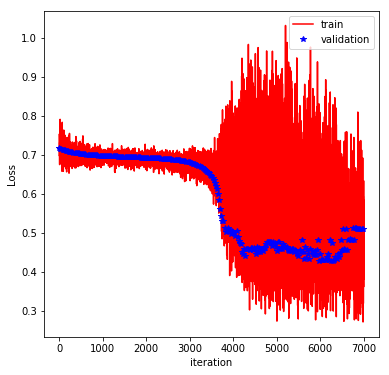

In [14]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

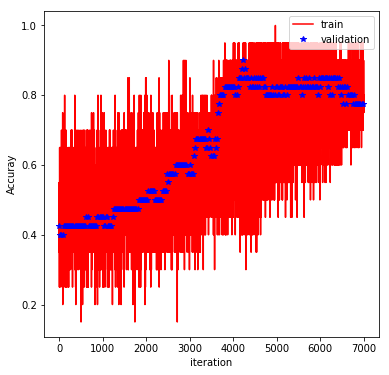

In [15]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [16]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
Test accuracy: 0.405000
